# Modelado de la función sinusoidal con NeuralODEs

In [120]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions

Para esto tenémos que crear una ecuación diferencial parametrizada que me permita aprender la solución que buscamos. En este caso le damos a la NeuralODE una dinámica que es una combinación de funciones sinusoidales, con esto la NeuralODE debería ser capaz de entrenar los parámetros para poder llegar al resultado correcto.

In [138]:
function parametric_ode_system!(du,u,p,t)
    y = u
    ω, A, B = p
    du[1] = dy = A*cos(ω*2π*t) + B*sin(ω*2π*t)
  end;

Ahora seteamos el tiempo de simulación y los parámetros de la ecuación diferencial, como así la condición inicial del problema la cual es la posición inicial en 0.

In [139]:
tbegin = -1
tstep = 0.01
tend = 1
trange = tbegin:tstep:tend
p = ones(3)
tspan = (tbegin, tend)
u0 = [0.0];

Creamos el problema de ecuaciones diferenciales parametrizado. Además creamos lo que sería nuestra red neuronal que consiste en el resolvedor de ODEs.

In [140]:
prob = ODEProblem(parametric_ode_system!, u0, tspan, p)
function net()
    solve(prob, Tsit5(), p=p, saveat=trange)
end
sol = net()
x = vcat(sol.u...);

Generamos los datos de entrenamiento y datos de prueba de la función sinusoidal con ruido gaussiano

In [141]:
function sine_with_noise(t)
    return sin(2π*t) + rand(Normal(0,0.1))
end;

In [142]:
dataset_outs = [sine_with_noise.(trange)]
test_dataset = [sine_with_noise.(trange)];

Graficamos hora sí tanto solución de la ecuación diferencial como los datos de entrenamiento. Esto dependiendo de las condiciones iniciales aleatorias que se setearon puede estar cerca o lejos de la función sinusoidal con ruido

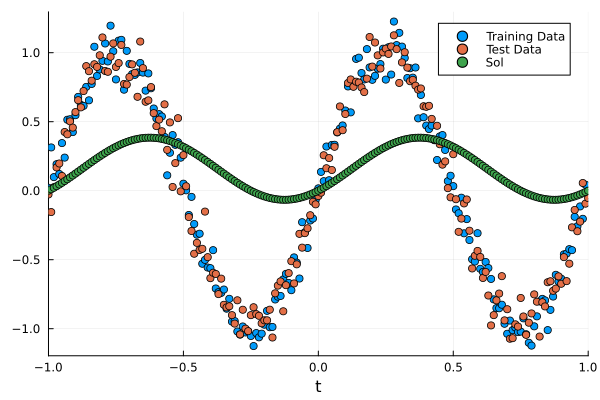

In [143]:
scatter(trange, dataset_outs, label = "Training Data")
scatter!(trange, test_dataset, label = "Test Data")
scatter!(sol, label = "Sol")

Creamos la función loss que es la diferencia entre la solución de la ecuación diferencial y los datos de entrenamiento

In [144]:
function loss_func()
    pred = net()
    pred = vcat(pred.u...)
    sum(abs2, dataset_outs[1] .- pred)
  end;

In [145]:
function loss_func2()
    pred = net()
    pred = vcat(pred.u...)
    sum(abs2, test_dataset[1] .- pred)
  end

loss_func2 (generic function with 1 method)

Creamos una función para ver la predicción de la red neuronal en cada época

In [146]:
function accuracy(y)
    num_correct = 0
    predictions = net()
    predictions = vcat(predictions.u...)
    for i in 1:length(predictions)
        if abs(predictions[i] - y[1][i]) < 0.2
            num_correct += 1
        end
    end
    return (num_correct/length(predictions)) * 100.0
end;

Ahora entrenamos la red durante 50 épocas con el método de optimización Adam y un learning rate de 0.1, además en cada época guardamos los datos del loss y la presición

In [147]:
epochs = 150
learning_rate = 0.1
data = Iterators.repeated((), epochs)
opt = ADAM(learning_rate)
iter = 0
losses = []
losses_test = []
accuracys = []
accuracys_test = []
cb = function () #callback function to observe training
  global iter += 1
  actual_loss = loss_func()
  println("Epoch: $iter | Loss: $actual_loss")
  push!(losses, actual_loss)
  push!(losses_test, loss_func2())
  push!(accuracys, accuracy(dataset_outs))
  push!(accuracys_test, accuracy(test_dataset))
  #plt = plot(solve(remake(prob, p=p), Tsit5()))
  #scatter!(trange, dataset_outs)
  #display(plt)
  #display(plot(solve(remake(prob,p=p),Tsit5()));
  #        scatter!(trange,dataset_outs))
end
fparams = Flux.params(p)

cb()

Flux.train!(loss_func, fparams, data, opt, cb=cb)

Epoch: 1 | Loss: 79.30320175841256


Epoch: 2 | Loss: 69.4055025718915
Epoch: 3 | Loss: 70.82977991468033
Epoch: 4 | Loss: 67.10812507586068
Epoch: 5 | Loss: 61.44801259189618
Epoch: 6 | Loss: 58.561259447285835
Epoch: 7 | Loss: 57.866556462568575
Epoch: 8 | Loss: 55.95321935584679
Epoch: 9 | Loss: 52.28576997008073
Epoch: 10 | Loss: 48.969830389800556
Epoch: 11 | Loss: 47.75472451348843
Epoch: 12 | Loss: 46.713868543446104
Epoch: 13 | Loss: 43.87202776450467
Epoch: 14 | Loss: 40.97316976203219
Epoch: 15 | Loss: 39.779876347323736
Epoch: 16 | Loss: 38.70737457963116
Epoch: 17 | Loss: 36.2075034917834
Epoch: 18 | Loss: 33.816553168365175


Epoch: 19 | Loss: 32.89823378108419
Epoch: 20 | Loss: 31.524168986589782
Epoch: 21 | Loss: 29.119644200752155
Epoch: 22 | Loss: 27.772756891600462
Epoch: 23 | Loss: 26.90112207892468
Epoch: 24 | Loss: 24.963225734216433
Epoch: 25 | Loss: 23.42891783836815
Epoch: 26 | Loss: 22.74185514884499
Epoch: 27 | Loss: 21.10619150752301
Epoch: 28 | Loss: 19.79072543056247
Epoch: 29 | Loss: 19.137654744057333
Epoch: 30 | Loss: 17.680459890951692
Epoch: 31 | Loss: 16.70286642700404
Epoch: 32 | Loss: 16.01563822578424
Epoch: 33 | Loss: 14.704754201903894
Epoch: 34 | Loss: 14.14071561884068
Epoch: 35 | Loss: 13.221026526972816


Epoch: 36 | Loss: 12.330277693037107
Epoch: 37 | Loss: 11.833460430808369
Epoch: 38 | Loss: 10.855486526460572
Epoch: 39 | Loss: 10.447742199198887
Epoch: 40 | Loss: 9.641857241232135
Epoch: 41 | Loss: 9.162088901367918
Epoch: 42 | Loss: 8.565229812641713
Epoch: 43 | Loss: 8.036637204454976
Epoch: 44 | Loss: 7.5916519549727015
Epoch: 45 | Loss: 7.065044927629621
Epoch: 46 | Loss: 6.710327195727029
Epoch: 47 | Loss: 6.235553846046696
Epoch: 48 | Loss: 5.925657452470442
Epoch: 49 | Loss: 5.521816238669798
Epoch: 50 | Loss: 5.233707781469168
Epoch: 51 | Loss: 4.918202072474228
Epoch: 52 | Loss: 4.6295389144018415
Epoch: 53 | Loss: 4.405793477720561
Epoch: 54 | Loss: 4.1109313465369
Epoch: 55 | Loss: 3.9616166184131574
Epoch: 56 | Loss: 3.6898300533201125
Epoch: 57 | Loss: 3.56194079898567
Epoch: 58 | Loss: 3.3659030469865114
Epoch: 59 | Loss: 3.201568330676768
Epoch: 60 | Loss: 3.099349676230192
Epoch: 61 | Loss: 2.9230958482960143
Epoch: 62 | Loss: 2.8345269376751183
Epoch: 63 | Loss: 2.


Epoch: 71 | Loss: 2.166475763081493
Epoch: 72 | Loss: 2.1401373804301547
Epoch: 73 | Loss: 2.094842937265872
Epoch: 74 | Loss: 2.053386411382285
Epoch: 75 | Loss: 2.034907426590739
Epoch: 76 | Loss: 2.0196747793122407
Epoch: 77 | Loss: 1.9922096762675616
Epoch: 78 | Loss: 1.9652824094772745
Epoch: 79 | Loss: 1.9514557663923717
Epoch: 80 | Loss: 1.9459650301787177
Epoch: 81 | Loss: 1.9379815743383082
Epoch: 82 | Loss: 1.9239749655587286
Epoch: 83 | Loss: 1.9097206690767128
Epoch: 84 | Loss: 1.9003475744019345
Epoch: 85 | Loss: 1.8967912916323464
Epoch: 86 | Loss: 1.8965915640987636
Epoch: 87 | Loss: 1.8966888159102098
Epoch: 88 | Loss: 1.8960981119433573
Epoch: 89 | Loss: 1.894157257618122
Epoch: 90 | Loss: 1.892202168134357
Epoch: 91 | Loss: 1.8902355621634244
Epoch: 92 | Loss: 1.8896244657192707
Epoch: 93 | Loss: 1.8902623913589585
Epoch: 94 | Loss: 1.8939103906321033
Epoch: 95 | Loss: 1.9014149544302033
Epoch: 96 | Loss: 1.9180395288580958
Epoch: 97 | Loss: 1.9490952837967073
Epoch:


Epoch: 103 | Loss: 2.2200805988825434
Epoch: 104 | Loss: 1.9093241686984017
Epoch: 105 | Loss: 1.9370758753068544
Epoch: 106 | Loss: 2.171816091938409
Epoch: 107 | Loss: 2.249463558840282
Epoch: 108 | Loss: 2.0164186091994343
Epoch: 109 | Loss: 1.875353154623832
Epoch: 110 | Loss: 1.995598662741045
Epoch: 111 | Loss: 2.109876543834959
Epoch: 112 | Loss: 2.027365077441993
Epoch: 113 | Loss: 1.8853717569544368
Epoch: 114 | Loss: 1.9199097113682708
Epoch: 115 | Loss: 2.0288547100633334
Epoch: 116 | Loss: 1.998604584914562
Epoch: 117 | Loss: 1.896964850574226
Epoch: 118 | Loss: 1.8871666060985908
Epoch: 119 | Loss: 1.9587628099197505
Epoch: 120 | Loss: 1.975957806493003
Epoch: 121 | Loss: 1.9084751530330981
Epoch: 122 | Loss: 1.875244623109423
Epoch: 123 | Loss: 1.9142961801462561
Epoch: 124 | Loss: 1.9443018886013907
Epoch: 125 | Loss: 1.917950691447641


Epoch: 126 | Loss: 1.878264474743901
Epoch: 127 | Loss: 1.8839111666026371
Epoch: 128 | Loss: 1.9146157175147953
Epoch: 129 | Loss: 1.9171282176002054
Epoch: 130 | Loss: 1.891478237636161
Epoch: 131 | Loss: 1.874311787446323
Epoch: 132 | Loss: 1.885282181847131
Epoch: 133 | Loss: 1.9028817603974533
Epoch: 134 | Loss: 1.9005562680481427
Epoch: 135 | Loss: 1.884171366992361
Epoch: 136 | Loss: 1.8741675263375344
Epoch: 137 | Loss: 1.8801493291830138
Epoch: 138 | Loss: 1.8912027871464892
Epoch: 139 | Loss: 1.8925440617008475
Epoch: 140 | Loss: 1.884280298687874
Epoch: 141 | Loss: 1.8755488384663193
Epoch: 142 | Loss: 1.874809136353045
Epoch: 143 | Loss: 1.8806030797672308
Epoch: 144 | Loss: 1.8855568537117107


Epoch: 145 | Loss: 1.885321642932587
Epoch: 146 | Loss: 1.8802736856035989
Epoch: 147 | Loss: 1.8754638646240156
Epoch: 148 | Loss: 1.874084471782179
Epoch: 149 | Loss: 1.8762369114041757
Epoch: 150 | Loss: 1.879581792836931
Epoch: 151 | Loss: 1.881330409808493


Una vez entrenada la NeuralODE, lo que hacemos es graficar los datos de entenamiento y los de la predicción de la red neuronal. Como se puede ver la red neuronal aprendió la función sinusoidal con ruido. Para esto lo que se logró es que los parámetros se actualicen de tal forma de que la solución de la ecuación diferencial se acerque a los datos de entrenamiento. Es por esto que volvemos a resovler el problema con los nuevos parámetros actualizados $p$

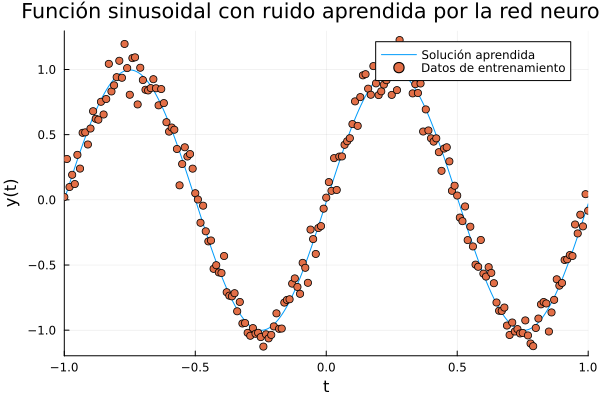

In [148]:
plot(solve(remake(prob, p=p), Tsit5()), label = "Solución aprendida", title = "Función sinusoidal con ruido aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, dataset_outs, label = "Datos de entrenamiento")

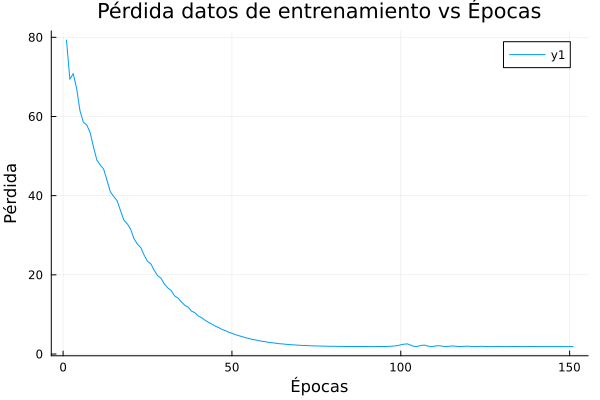

In [149]:
plot(losses, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de enetrenamiento: 96.01990049751244


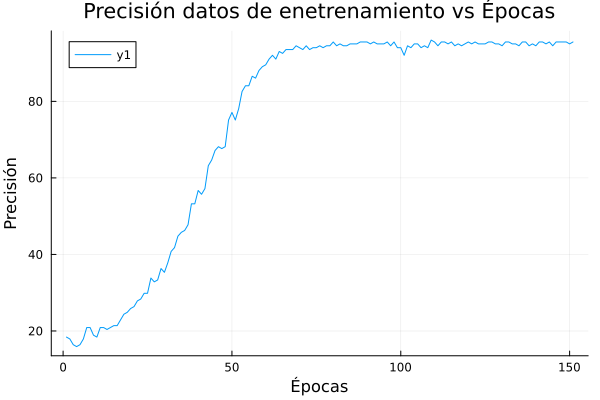

In [150]:
println("Maxima precisión en datos de enetrenamiento: ", maximum(accuracys))
plot(accuracys, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de enetrenamiento vs Épocas")

# Veamos con los datos de prueba

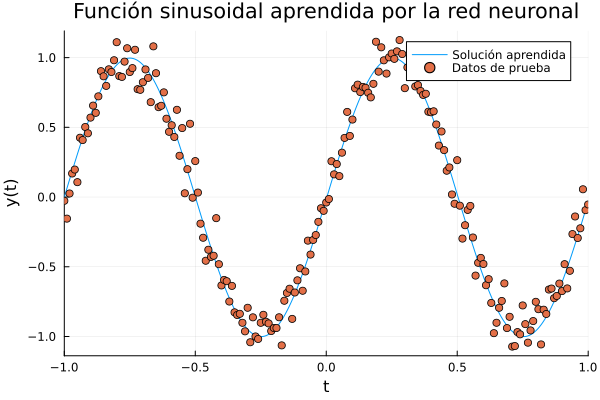

In [152]:
plot(solve(remake(prob, p=p), Tsit5()), label = "Solución aprendida", title = "Función sinusoidal aprendida por la red neuronal",
ylabel = "y(t)")
scatter!(trange, test_dataset, label = "Datos de prueba")

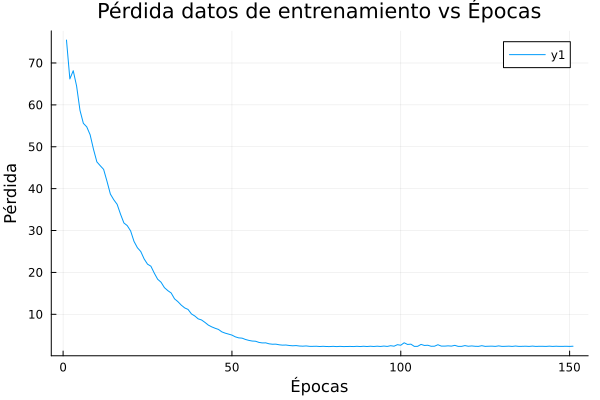

In [153]:
plot(losses_test, xlabel = "Épocas", ylabel = "Pérdida", title = "Pérdida datos de entrenamiento vs Épocas")

Maxima precisión en datos de prueba: 93.03482587064677


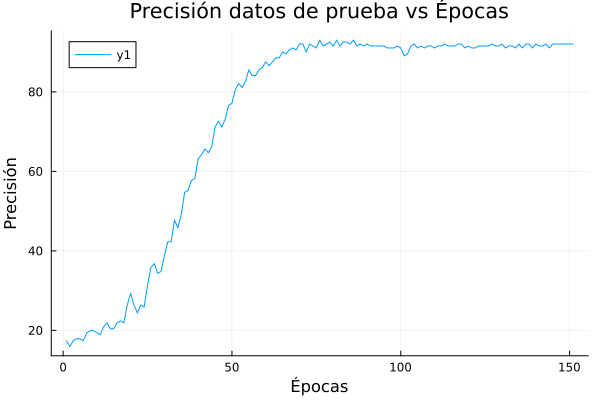

In [154]:
println("Maxima precisión en datos de prueba: ", maximum(accuracys_test))
plot(accuracys_test, xlabel = "Épocas", ylabel = "Precisión", title = "Precisión datos de prueba vs Épocas")

Como vemos esta NeuralODE comparada con los métodos anteriores mejora la presición en los datos de entrenamiento comparada con la red de varias capas que se creó con la red neuronal Feedfoward. Sin embargo esto depende mucho de las condiciones iniciales que se le de a la ecuación diferencial.